In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acknowledgment:
# We express our sincere gratitude to the developers and contributors of the
# DGL library, particularly the example implementation of APPNP available at:
# https://github.com/dmlc/dgl/blob/master/examples/sparse/appnp.py
# This work served as a foundational reference and inspiration for our implementation.


In [ ]:
!pip install torch==2.1.0+cu121 torchvision==0.16.0+cu121 torchaudio==2.1.0+cu121 \
  --index-url https://download.pytorch.org/whl/cu121
!pip install dgl==2.4.0+cu121 -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
!pip install --force-reinstall numpy==1.26.4
!pip install lime matplotlib scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 538.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling torc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f139b8e27817ccb91668b3b072688ecf11d271a9ab5c29595cd781eede431891
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
^C


In [1]:
import dgl
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# from lime.lime_tabular import LimeTabularExplainer

/home/snu/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === Load Patients ===
fa_patients_path = "/home/snu/Downloads/NIFD_Patients_FA_Histogram_Feature.npy"
Patients_FA_array = np.load(fa_patients_path, allow_pickle=True)

# === Load Controls ===
fa_controls_path = "/home/snu/Downloads/NIFD_Control_FA_Histogram_Feature.npy"
Controls_FA_array = np.load(fa_controls_path, allow_pickle=True)

print("Patients Shape:", Patients_FA_array.shape)
print("Controls Shape:", Controls_FA_array.shape)

# === Combine features and labels ===
X = np.vstack([Controls_FA_array, Patients_FA_array])
y = np.hstack([
    np.zeros(Controls_FA_array.shape[0], dtype=np.int64),  # 0 = Control
    np.ones(Patients_FA_array.shape[0], dtype=np.int64)    # 1 = Patient
])

# Shuffle
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

Patients Shape: (98, 180)
Controls Shape: (48, 180)


In [3]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
num_nodes = X.shape[0]
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [5]:
alpha = 0 # threshold
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)

src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src = src[mask]
dst = dst[mask]

graph = dgl.graph((src.cpu(), dst.cpu()), num_nodes=num_nodes, device='cpu')
graph = dgl.to_bidirected(graph)
graph = dgl.add_self_loop(graph)

graph = graph.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

Graph Nodes: 146, Edges: 10046, Device: cuda


In [ ]:
# edge_index = torch.combinations(torch.arange(num_nodes), r=2).T
# src, dst = edge_index
# graph = dgl.graph((src, dst))
# graph = dgl.to_bidirected(graph)
# graph = dgl.add_self_loop(graph)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# graph = graph.to(device)
# X_tensor = X_tensor.to(device)
# y_tensor = y_tensor.to(device)

# print(f"Graph Nodes: {graph.num_nodes()}, Edges: {graph.num_edges()}, Device: {device}")

Graph Nodes: 300, Edges: 90000, Device: cuda


In [6]:
class APPNP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size=512, dropout=0.2, num_hops=10, alpha=0.2):
        super().__init__()
        self.f_theta = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, out_size),
        )
        self.num_hops = num_hops
        self.A_dropout = nn.Dropout(dropout)
        self.alpha = alpha

    def forward(self, A_hat, X):
        Z_0 = Z = self.f_theta(X)
        for _ in range(self.num_hops):
            A_drop = dglsp.val_like(A_hat, self.A_dropout(A_hat.val))
            Z = (1 - self.alpha) * (A_drop @ Z) + self.alpha * Z_0
        return Z

In [7]:
indices = torch.stack(graph.edges())
N = graph.num_nodes()
A = dglsp.spmatrix(indices, shape=(N, N))
I = dglsp.identity(A.shape, device=device)
A_hat = A + I
D_hat = dglsp.diag(A_hat.sum(dim=1)) ** -0.5
A_hat = D_hat @ A_hat @ D_hat

In [8]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 5000

accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []
all_y_true, all_y_proba, all_fpr, all_tpr, all_auc = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    cn_train = np.sum(y[train_idx] == 0)
    mci_train = np.sum(y[train_idx] == 1)
    cn_test = np.sum(y[test_idx] == 0)
    mci_test = np.sum(y[test_idx] == 1)
    print(f"Training samples (CN): {cn_train}, (MCI): {mci_train}")
    print(f"Testing samples (CN): {cn_test}, (MCI): {mci_test}")

    model = APPNP(in_size=X.shape[1], out_size=2, hidden_size=512, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(A_hat, X_tensor)
        loss = loss_fn(out[train_mask], y_tensor[train_mask])

        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN or Inf loss detected at epoch {epoch}, stopping training.")
            break

        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(A_hat, X_tensor)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()

    accuracy = accuracy_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    precision = precision_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    recall = recall_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    f1 = f1_score(y_true_test, y_pred[test_mask.cpu().numpy()])
    cross_entropy_loss = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(cross_entropy_loss)

    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_pred_proba[:, 1][test_mask.cpu().numpy()])
    fpr, tpr, _ = roc_curve(y_true_test, y_pred_proba[:, 1][test_mask.cpu().numpy()])
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc(fpr, tpr))

    print(f"\nFold {fold + 1} Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Cross-Entropy Loss: {cross_entropy_loss:.4f}")
    print("-" * 50)

print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")



Training fold 1
Training samples (CN): 5, (MCI): 9
Testing samples (CN): 43, (MCI): 89

Fold 1 Evaluation:
Accuracy: 0.6970
Precision: 0.7526
Recall: 0.8202
F1 Score: 0.7849
Cross-Entropy Loss: 0.9869
--------------------------------------------------

Training fold 2
Training samples (CN): 5, (MCI): 9
Testing samples (CN): 43, (MCI): 89

Fold 2 Evaluation:
Accuracy: 0.6742
Precision: 0.7875
Recall: 0.7079
F1 Score: 0.7456
Cross-Entropy Loss: 0.6412
--------------------------------------------------

Training fold 3
Training samples (CN): 5, (MCI): 9
Testing samples (CN): 43, (MCI): 89

Fold 3 Evaluation:
Accuracy: 0.6818
Precision: 0.7196
Recall: 0.8652
F1 Score: 0.7857
Cross-Entropy Loss: 1.0006
--------------------------------------------------

Training fold 4
Training samples (CN): 5, (MCI): 9
Testing samples (CN): 43, (MCI): 89

Fold 4 Evaluation:
Accuracy: 0.6591
Precision: 0.7500
Recall: 0.7416
F1 Score: 0.7458
Cross-Entropy Loss: 0.7713
---------------------------------------

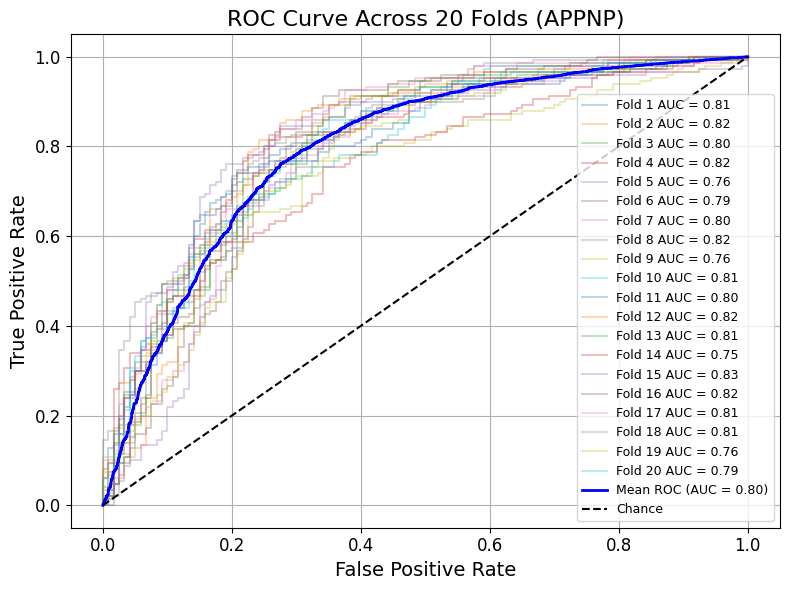

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (APPNP)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

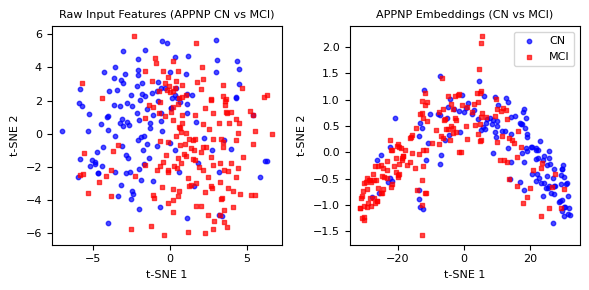

In [ ]:
X_input = X_tensor.cpu().numpy()
tsne_input = TSNE(n_components=2, init='pca', random_state=42)
input_2d = tsne_input.fit_transform(X_input)

model.eval()
with torch.no_grad():
    # Get final APPNP embeddings (after propagation)
    Z = model(A_hat, X_tensor).cpu().numpy()

tsne_embed = TSNE(n_components=2, init='pca', random_state=42)
embed_2d = tsne_embed.fit_transform(Z)

labels = y_tensor.cpu().numpy()

colors = ['blue', 'red']
markers = ['o', 's']
class_names = ['CN', 'MCI']
font_size = 8

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot raw input t-SNE
for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[0].scatter(input_2d[idx, 0], input_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[0].set_title("Raw Input Features (APPNP CN vs MCI)", fontsize=font_size)
axes[0].set_xlabel("t-SNE 1", fontsize=font_size)
axes[0].set_ylabel("t-SNE 2", fontsize=font_size)
axes[0].tick_params(labelsize=font_size)

# Plot APPNP embeddings t-SNE
for cls, color, marker in zip([0, 1], colors, markers):
    idx = labels == cls
    axes[1].scatter(embed_2d[idx, 0], embed_2d[idx, 1],
                    c=color, marker=marker, label=class_names[cls], alpha=0.7, s=10)
axes[1].set_title("APPNP Embeddings (CN vs MCI)", fontsize=font_size)
axes[1].set_xlabel("t-SNE 1", fontsize=font_size)
axes[1].set_ylabel("t-SNE 2", fontsize=font_size)
axes[1].tick_params(labelsize=font_size)
axes[1].legend(fontsize=font_size, loc='best')

plt.tight_layout()
plt.savefig("tsne_appnp_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
